# Final Report: Predicting Student Placement Outcomes Using Logistic Regression
#### April 2025
#### Vaibhav Hari

## Introduction

As universities strive to improve student outcomes, understanding the key factors that influence placement success post graduation has become increasingly important. An in-depth look into real-world data reveals that, not just academic performance, but factors like experience and personal development, also contribute to a student’s placement prospects. 

#### Question for Investigation
Can we accurately predict whether a student will be placed based on their academic, co-curricular, and skill-based features?

In this project, we aim to develop a predictive model to determine whether a student will secure placement based on various features. Specifically, we use indicators of academic performance (such as CGPA, SSC, and HSC marks), professional experience (including the number of internships and projects), and personal development metrics (such as workplace participation, involvement in extracurricular activities, and participation in placement training) as input variables. Our goal is to identify which combination of these variables most accurately predicts a student’s placement status. This type of predictive modeling can help institutions identify at-risk students early and provide targeted support to improve their employability.

## Methods and Results

In [1]:
library(tidyverse)
library(broom)
library(rsample)
library(car)
library(caret)
library(glmnet)
library(pROC)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:purrr’:

    some


Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loa

### a) Data
The dataset contains 10,000 observations and 12 variables related to students' placement status. Each row represents a single student. It includes numeric variables such as CGPA, internships, projects, and test scores, as well as categorical variables like extracurricular activities and placement status. The primary goal of the dataset is to provide insights into how various academic and extracurricular factors might influence whether a student is placed.

- Number of observations: 10000
- StudentID (Integer, numeric) - It is a unique identifier for each student.
- CGPA (Integer, numeric) - It is the overall grades achieved by the student.
- Internships (Float/Double, numeric) - It tells the number of internships a student has done.
- Projects (Integer, numeric) - Number of projects a student has done.
- Workshops/Certifications (Integer, numeric) - As there are multiple courses available online student opt for them to upskill themselves.
- ApptitudeTestScore (Integer, numeric) - Aptitude test are generally a part of the recruitment process to understand the Quant and logical thinking of the student.
- SoftSkillrating (Float/Double, numeric) - Communication is a key role that plays in the placement or in any aspect of the life.
- ExtraCurricularActivities (Character, categorical) - This helps provide and insight about the personality of an individual regarding how much he is active other than the academic.
- PlacementTraining (Character, categorical) - It is provided to students in college to ace the placement process.
- SSC (Integer, numeric) - Senior Secondary Marks.
- HSC (Integer, numeric) - Higher Secondary Marks.
- PlacementStatus (Character, categorical) - This is our target column with two classes placed and not placed.

#### Pre-selection of variables
We'll not use StudentID as an explanatory variable because it is merely a unique identifier for each student and does not carry any meaningful information about their placement status. 

#### Load the Dataset

In [2]:

# Load the dataset
placement_data <- read_csv("https://github.com/vhari01/Placement_Data_Analysis/blob/main/placementdata.csv")

Rows: 10000 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): ExtracurricularActivities, PlacementTraining, PlacementStatus
dbl (9): StudentID, CGPA, Internships, Projects, Workshops/Certifications, A...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### b) Exploratory Data Analysis (EDA)

In [3]:

# Drop StudentID and convert categorical variables to factors
placement_data <- placement_data %>% 
select(-StudentID) %>%
  mutate(
    PlacementStatus = factor(PlacementStatus, levels = c("NotPlaced", "Placed")),
    ExtracurricularActivities = factor(ExtracurricularActivities, levels = c("No", "Yes")),
    PlacementTraining = factor(PlacementTraining, levels = c("No", "Yes"))
  )

head(placement_data)

# Check for missing values
sum(is.na(placement_data))

# View dataset structure
str(placement_data)

CGPA,Internships,Projects,Workshops/Certifications,AptitudeTestScore,SoftSkillsRating,ExtracurricularActivities,PlacementTraining,SSC_Marks,HSC_Marks,PlacementStatus
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>
7.5,1,1,1,65,4.4,No,No,61,79,NotPlaced
8.9,0,3,2,90,4.0,Yes,Yes,78,82,Placed
7.3,1,2,2,82,4.8,Yes,No,79,80,NotPlaced
7.5,1,1,2,85,4.4,Yes,Yes,81,80,Placed
8.3,1,2,2,86,4.5,Yes,Yes,74,88,Placed
7.0,0,2,2,71,4.2,Yes,No,55,66,NotPlaced


[1] 0

tibble [10,000 × 11] (S3: tbl_df/tbl/data.frame)
 $ CGPA                     : num [1:10000] 7.5 8.9 7.3 7.5 8.3 7 7.7 7.7 6.5 7.8 ...
 $ Internships              : num [1:10000] 1 0 1 1 1 0 1 2 1 1 ...
 $ Projects                 : num [1:10000] 1 3 2 1 2 2 1 1 1 3 ...
 $ Workshops/Certifications : num [1:10000] 1 2 2 2 2 2 1 0 0 2 ...
 $ AptitudeTestScore        : num [1:10000] 65 90 82 85 86 71 76 85 84 79 ...
 $ SoftSkillsRating         : num [1:10000] 4.4 4 4.8 4.4 4.5 4.2 4 3.5 3.9 4.4 ...
 $ ExtracurricularActivities: Factor w/ 2 levels "No","Yes": 1 2 2 2 2 2 1 2 1 2 ...
 $ PlacementTraining        : Factor w/ 2 levels "No","Yes": 1 2 1 2 2 1 1 2 2 2 ...
 $ SSC_Marks                : num [1:10000] 61 78 79 81 74 55 62 59 75 85 ...
 $ HSC_Marks                : num [1:10000] 79 82 80 80 88 66 65 72 71 86 ...
 $ PlacementStatus          : Factor w/ 2 levels "NotPlaced","Placed": 1 2 1 2 2 1 1 1 1 2 ...


#### Visualizations

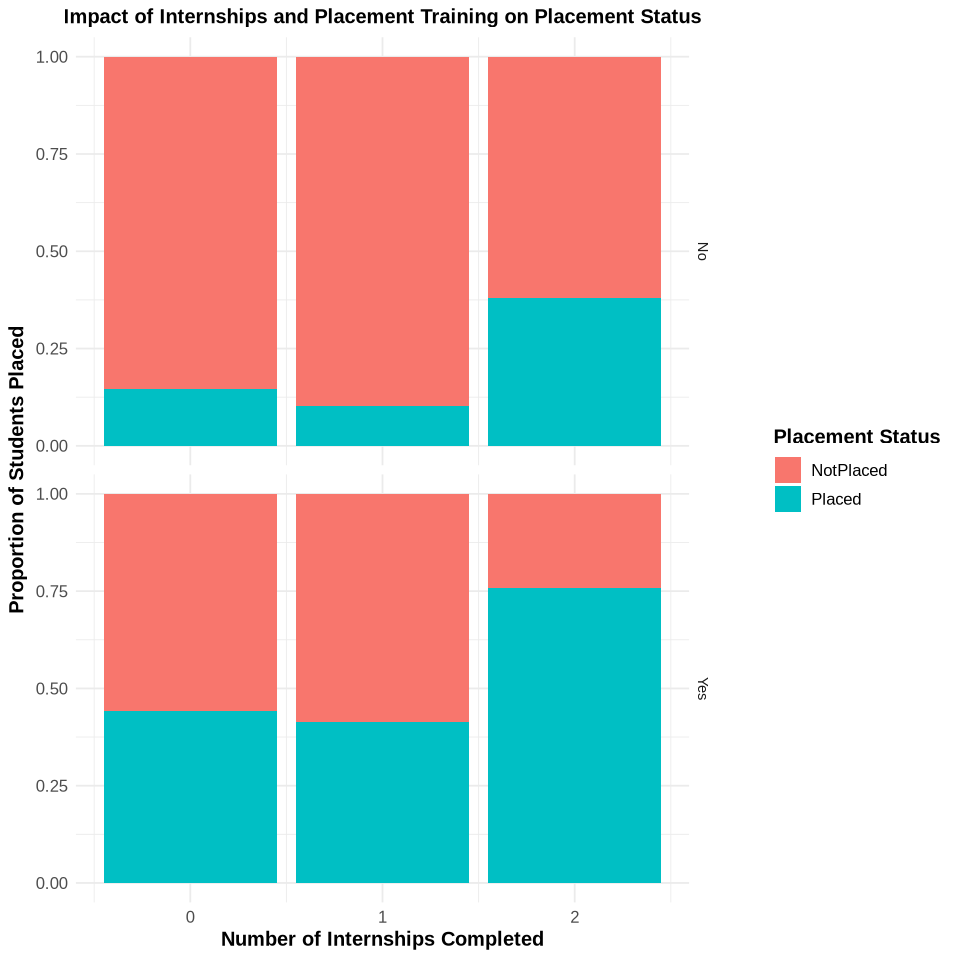

In [4]:

options(repr.plot.width = 8, repr.plot.height = 8)
ggplot(placement_data, aes(x = Internships, fill = PlacementStatus)) +
  geom_bar(position = "fill") +
    facet_grid("PlacementTraining") +
  labs(
    title = "Impact of Internships and Placement Training on Placement Status",
    x = "Number of Internships Completed",
    y = "Proportion of Students Placed",
    fill = "Placement Status",
  ) +
    theme_minimal() +
    theme(
        legend.title = element_text(size = 12, face = "bold"),
        legend.text = element_text(size = 10),
        legend.position = "right",
        legend.box.spacing = unit(1, "cm"),
        axis.title = element_text(size = 12, face = "bold"),
        axis.text = element_text(size = 10),
        plot.title = element_text(size = 12, face = "bold", hjust = 0.5)
    )

- Placement Status (Response Variable)
- Number of Internships (X-axis)
- Placement Training (Row Facet)

Our exploratory data analysis revealed that professional experience and placement training significantly impact placement outcomes. 

The stacked bar chart shows a clear trend that students who completed more internships were more likely to be placed, especially when they also participated in placement training. Among those who completed two internships and received training, the placement rate was substantially higher compared to those who had no internships or skipped training. This suggests that hands-on experience and institutional preparation programs play a vital role in boosting placement chances.


In [5]:

# 1. Split data into two parts
df_placed <- placement_data %>% filter(PlacementStatus == "Placed")
df_not_placed <- placement_data %>% filter(PlacementStatus == "NotPlaced")

# 2. Create a correlation matrix for Placed and NotPlaced students
corr_matrix_placed <- 
    df_placed %>%
    select(where(is.numeric)) %>%
    cor() %>%
    as_tibble(rownames = 'var1') %>%
    pivot_longer(-var1, names_to = "var2", values_to = "corr")
head(corr_matrix_placed)

corr_matrix_not_placed <- 
    df_not_placed %>%
    select(where(is.numeric)) %>%
    cor() %>%
    as_tibble(rownames = 'var1') %>%
    pivot_longer(-var1, names_to = "var2", values_to = "corr")
head(corr_matrix_not_placed)

var1,var2,corr
<chr>,<chr>,<dbl>
CGPA,CGPA,1.0000000
CGPA,Internships,0.2347647
CGPA,Projects,0.3152994
CGPA,Workshops/Certifications,0.2773790
CGPA,AptitudeTestScore,0.3593718
CGPA,SoftSkillsRating,0.3116075


var1,var2,corr
<chr>,<chr>,<dbl>
CGPA,CGPA,1.0000000
CGPA,Internships,0.1666781
CGPA,Projects,0.2816741
CGPA,Workshops/Certifications,0.2015649
CGPA,AptitudeTestScore,0.2855055
CGPA,SoftSkillsRating,0.2155980


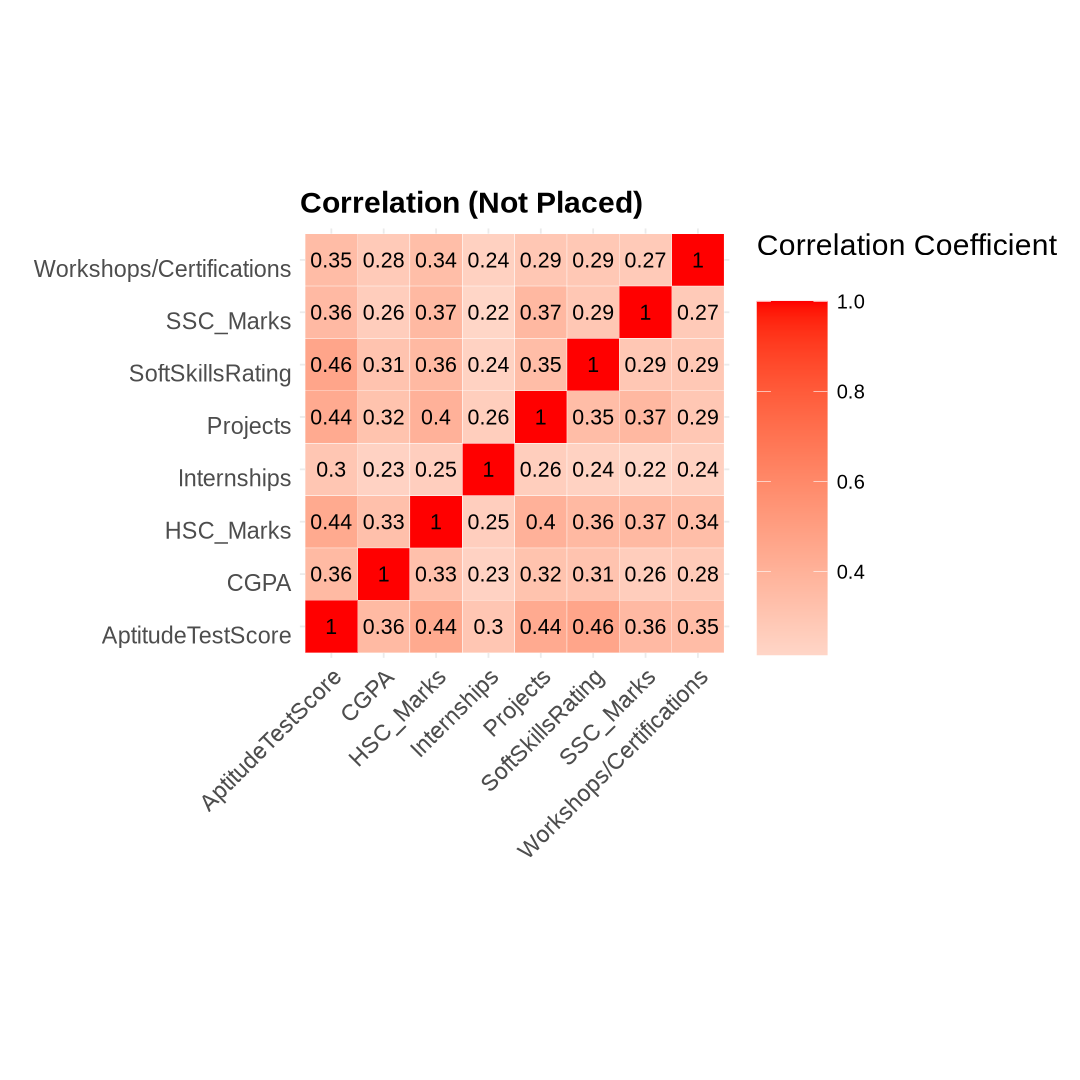

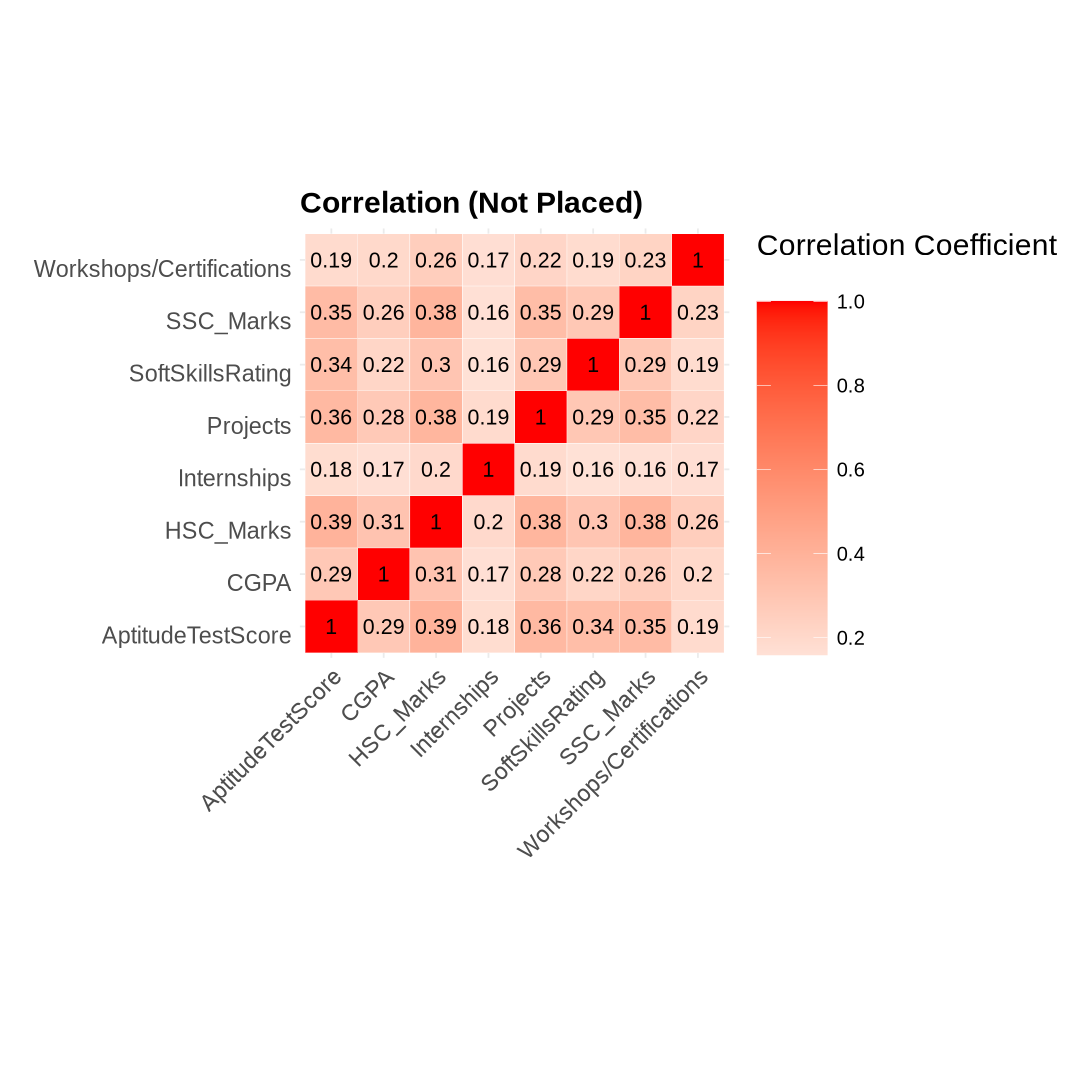

In [6]:

options(repr.plot.width = 9, repr.plot.height = 9)
# 3. Plotting the heatmap
plot_corr_matrix_placed <- 
    corr_matrix_placed %>%
    ggplot(aes(var1, var2)) +
    geom_tile(aes(fill = corr), color = "white") +
    scale_fill_gradient2("Correlation Coefficient \n",
                        low = "blue", mid = "white", high = "red", midpoint = 0
    ) +
    labs(title = "Correlation (Not Placed)", x = "", y = "") +
    theme_minimal() +
    theme(
        plot.title = element_text(size = 18, face = "bold"),
        axis.text.x = element_text(angle = 45, vjust = 1, size = 14, hjust = 1),
        axis.text.y = element_text(vjust = 1, size = 14, hjust = 1),
        legend.title = element_text(size = 18),
        legend.text = element_text(size = 12),
        legend.key.size = unit(1.5, "cm")
    ) +
    coord_fixed() +
    geom_text(aes(var2, var1, label = round(corr, 2)), color = "black", size = 4.5)
plot_corr_matrix_placed

plot_corr_matrix_not_placed <- 
    corr_matrix_not_placed %>%
    ggplot(aes(var1, var2)) +
    geom_tile(aes(fill = corr), color = "white") +
    scale_fill_gradient2("Correlation Coefficient \n",
                        low = "blue", mid = "white", high = "red", midpoint = 0
    ) +
    labs(title = "Correlation (Not Placed)", x = "", y = "") +
    theme_minimal() +
    theme(
        plot.title = element_text(size = 18, face = "bold"),
        axis.text.x = element_text(angle = 45, vjust = 1, size = 14, hjust = 1),
        axis.text.y = element_text(vjust = 1, size = 14, hjust = 1),
        legend.title = element_text(size = 18),
        legend.text = element_text(size = 12),
        legend.key.size = unit(1.5, "cm")
    ) +
    coord_fixed() +
    geom_text(aes(var2, var1, label = round(corr, 2)), color = "black", size = 4.5)
plot_corr_matrix_not_placed

### c) Methods: Plan

The primary goal is to predict the likelihood of a student being placed based on academic and extracurricular attributes. We begin by fitting a full logistic regression model including all ten predictors (excluding `StudentID`). To evaluate and enhance model generalizability, the dataset is randomly split into a training set (70%) and a test set (30%), stratified by the outcome variable `PlacementStatus`. To prevent overfitting and simplify the model, we apply LASSO (Least Absolute Shrinkage and Selection Operator) regularization with 10-fold cross-validation on the training set. This penalized regression method allows automatic variable selection by shrinking less important coefficients to zero. The final model is selected based on the $\lambda$ value that maximizes the area under the ROC curve (AUC). The selected model will be evaluated on the test set only to ensure an unbiased 
assessment of its performance.

This method is appropriate because `PlacementStatus` is a binary response with two levels: Placed and NotPlaced, and logistic regression models the probability of a categorical response and splitting dataset ensures that the model can generalize to unseen data. 

Logistic regression assumes the independence of observations, no extreme multicollinearity among predictors, linearity in the log-odds and a sufficient large sample size. 

Potential limitations include sensitivity to outliers and overfitting risks if predictors are correlated, which can be addressed by removing outliers and assessing variance inflation factors (VIF).

In [7]:

set.seed(1234) # Make sure the code is reproducible

# Split data into training (70%) and testing (30%) sets
placement_split <- placement_data %>% 
    initial_split(prop = 0.7, strata = PlacementStatus)

placement_training <- training(placement_split)
placement_testing <- testing(placement_split)

# Full logistic regression model
logit_model <- glm(PlacementStatus ~ . ,
                   data = placement_training, family = binomial)

In [8]:


# Check for multicollinearity
vif_values <- vif(logit_model)
vif_values

CGPA                Internships 
                  1.224946                   1.129136 
                  Projects `Workshops/Certifications` 
                  1.342033                   1.194569 
         AptitudeTestScore           SoftSkillsRating 
                  1.384785                   1.244820 
 ExtracurricularActivities          PlacementTraining 
                  1.280451                   1.025781 
                 SSC_Marks                  HSC_Marks 
                  1.318812                   1.475188

Since all vif values are smaller than 5, multicollinearity was not detected here!

#### Model Selection

In [9]:

# Prepare matrix for glmnet (excluding intercept)
model_matrix_X_train <- model.matrix(PlacementStatus ~ ., data = placement_training)[,-1]
head(model_matrix_X_train)

matrix_Y_train <- 
    as.matrix(placement_training$PlacementStatus, ncol = 1)
head(matrix_Y_train)

,CGPA,Internships,Projects,`Workshops/Certifications`,AptitudeTestScore,SoftSkillsRating,ExtracurricularActivitiesYes,PlacementTrainingYes,SSC_Marks,HSC_Marks
1,7.0,0,2,2,71,4.2,1,0,55,66
2,7.7,1,1,1,76,4.0,0,0,62,65
3,7.7,2,1,0,85,3.5,1,1,59,72
4,7.7,1,1,1,74,4.6,0,1,63,73
5,7.4,0,2,1,78,4.4,0,0,63,66
6,7.4,1,2,0,70,4.4,0,1,58,63


NotPlaced
NotPlaced
NotPlaced
NotPlaced
NotPlaced
NotPlaced


In our analysis, we will use LASSO regularization within a logistic regression model for variable selection. LASSO shrinks the coefficients of less important predictors to zero to select a subset of variables that best predict the binary outcome, PlacementStatus (Placed vs. NotPlaced). Since Ridge has been proposed as a method to address multicollinearity problems and we don't have this problem here, we prefer to use LASSO to select strong predictive models.

In [10]:
set.seed(1234)
# Apply LASSO with 10-fold cross-validation (optimize for AUC)
placement_cv_lambda_lasso <- 
  cv.glmnet(
       x = model_matrix_X_train, 
       y = matrix_Y_train,
       alpha = 1,
       family = "binomial",
       type.measure = "auc",
       nfolds = 10)
placement_cv_lambda_lasso


Call:  cv.glmnet(x = model_matrix_X_train, y = matrix_Y_train, type.measure = "auc",      nfolds = 10, alpha = 1, family = "binomial") 

Measure: AUC 

     Lambda Index Measure       SE Nonzero
min 0.00470    44  0.8758 0.004061       9
1se 0.05792    17  0.8723 0.004233       8

From this table, we can see that the best-performing model (according to cross-validation) has an AUC of about 0.8758. We choose **9 variables** here since we want to optimize the performance of our prediction model. 

An AUC of **0.8758** means there’s about an 87.58% chance that if you pick one student from the “placed” group and one student from the “not placed” group, the model’s predicted probabilities will rank the placed student higher than the not-placed student.

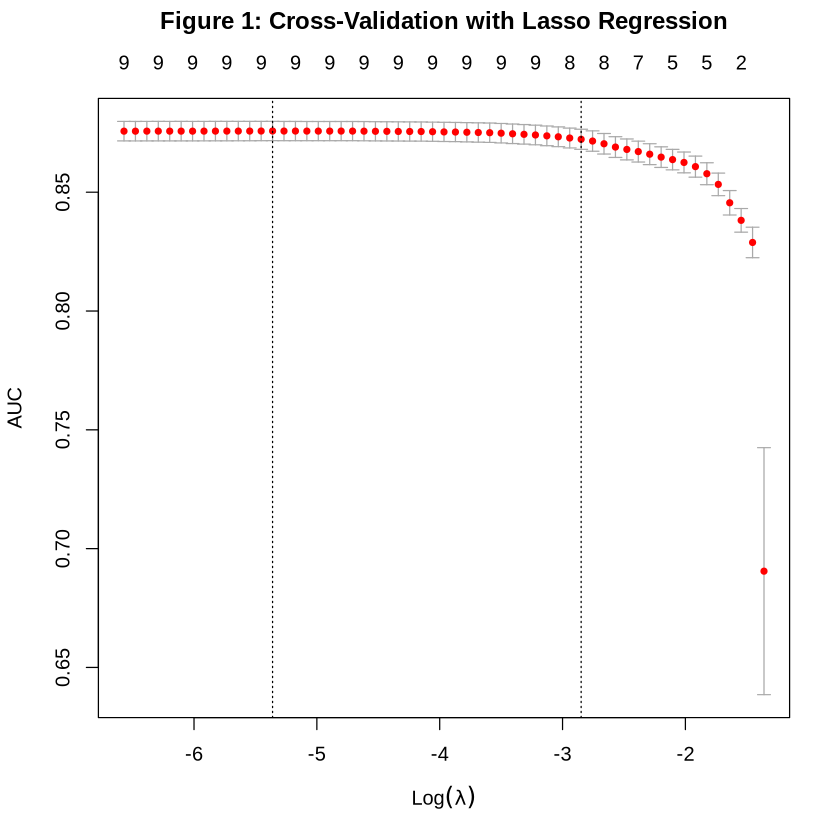

In [11]:

options(repr.plot.width = 7, repr.plot.height = 7)
# Visualization 1: cross-validation results (Figure 1)
plot(placement_cv_lambda_lasso, 
     main = "Figure 1: Cross-Validation with Lasso Regression\n\n")

The plot is a visualization of the result of cross-validation with LASSO regression. It shows that for very **small λ** (left side, less regularization), the **AUC is high**, which is 0.8758 and relatively stable.

As λ increases (moving to the right), the model is forced to drop some coefficients; you can see a slight dip in AUC, but it remains fairly competitive up until λ.1se.

Past a certain point (further right, large λ), the model underfits (AUC drops noticeably).

Therefore, as stated before, we will choose the λ with max AUC to optimize our model's performance.

In [12]:

# Extract optimal lambda
lambda_max_AUC_lasso <- round(placement_cv_lambda_lasso$lambda.min, 4)
lambda_max_AUC_lasso

[1] 0.0047

The lambda here is **0.0047** indicates that the penalty on each variable is not very large, so more coefficients are likely to remain nonzero. The model can stays more flexible and retains more predictors.

integer(0)

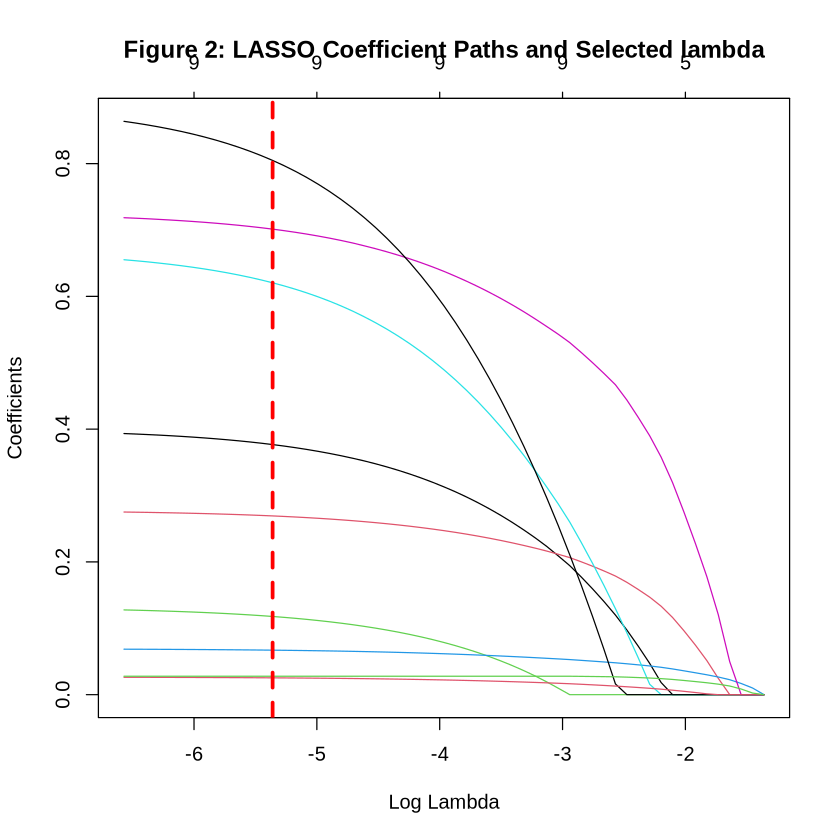

In [13]:

# Visualization 2: LASSO Coefficient Path (Figure 2)
plot(placement_cv_lambda_lasso$glmnet.fit, "lambda",
    main = "Figure 2: LASSO Coefficient Paths and Selected lambda") +
    abline(v = log(lambda_max_AUC_lasso), col = "red", lwd = 3, lty = 2)

This plot shows how **each predictor’s estimated coefficient** evolves with different levels of LASSO regularization, and the vertical red line pinpoints the λ that yielded our max **AUC (0.8758)**.

In [14]:

# Refit model with optimal lambda
final_model <- glmnet(
  x = model_matrix_X_train,
  y = matrix_Y_train,
  alpha = 1,
  lambda = lambda_max_AUC_lasso,
  family = "binomial"
)
final_model


Call:  glmnet(x = model_matrix_X_train, y = matrix_Y_train, family = "binomial",      alpha = 1, lambda = lambda_max_AUC_lasso) 

  Df  %Dev Lambda
1  9 35.99 0.0047

Here, we refit with the optimal Lambda to get our final model, **Df of 9** indicates our model has 9 variables after regularization.

**%Dev of 35.99** represents the **percent reduction in deviance** relative to the null model (the model with only an intercept).

In [15]:

# Table 1: Coefficients for each variable after model selection
coefs <- coef(final_model)
coefs

11 x 1 sparse Matrix of class "dgCMatrix"
                                       s0
(Intercept)                  -16.98696895
CGPA                           0.37675246
Internships                    .         
Projects                       0.26916420
`Workshops/Certifications`     0.11774079
AptitudeTestScore              0.06702806
SoftSkillsRating               0.62038487
ExtracurricularActivitiesYes   0.70124954
PlacementTrainingYes           0.80481622
SSC_Marks                      0.02535629
HSC_Marks                      0.02779001

This table shows the final LASSO logistic regression coefficients, the **"." in Internships** means this coefficient was **shrunk to zero by LASSO**. 

There are several notable predictors: **Placement Training (0.805)** and **Extracurricular Activities (0.701)**, both have remarkably large coefficients, which means that these factors strongly affect placement chances. Explained in terms of odds, a student's odds of being placed more than double after completing placement training or participating in extracurricular activities.

Now, we're going to evaluate our final model (from LASSO) on the test set!

In [16]:

# Prepare test data matrix
model_matrix_X_test <- 
    model.matrix(object = PlacementStatus ~ .,
                 data = placement_testing)[, -1]
matrix_Y_train <- 
    as.matrix(placement_testing$PlacementStatus, ncol = 1)

In [17]:


# Predict probabilities on the test set
prediciton_final <-  placement_testing %>%
    mutate(pred = round(predict(final_model, newx = model_matrix_X_test, type = "response")),  # Threshold at 0.5
           pred = if_else(pred == 0, "NotPlaced", "Placed"))

In [18]:

# Check the performance of the final model using confusion matrix
placement_confusion_matrix <- 
    confusionMatrix(
    data = as.factor(prediciton_final$pred),
    reference = as.factor(prediciton_final$PlacementStatus),
    positive = "Placed"
)
placement_confusion_matrix

Confusion Matrix and Statistics

           Reference
Prediction  NotPlaced Placed
  NotPlaced      1441    287
  Placed          300    973
                                          
               Accuracy : 0.8044          
                 95% CI : (0.7897, 0.8185)
    No Information Rate : 0.5801          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.5991          
                                          
 Mcnemar's Test P-Value : 0.6204          
                                          
            Sensitivity : 0.7722          
            Specificity : 0.8277          
         Pos Pred Value : 0.7643          
         Neg Pred Value : 0.8339          
             Prevalence : 0.4199          
         Detection Rate : 0.3242          
   Detection Prevalence : 0.4242          
      Balanced Accuracy : 0.8000          
                                          
       'Positive' Class : Placed          

In [19]:

# Convert confusion matrix to a table
# Table 1: Confusion Matrix for LASSO Model Predictions on Test Set
conf_matrix <- as.data.frame.matrix(placement_confusion_matrix$table)
colnames(conf_matrix) <- c("Not Placed (Ref)", "Placed (Ref)")
rownames(conf_matrix) <- c("Not Placed (Pred)", "Placed (Pred)")
conf_matrix
cat("Table 1: Confusion Matrix for LASSO Model Predictions on Test Set\n\n")

,Not Placed (Ref),Placed (Ref)
,<int>,<int>
Not Placed (Pred),1441,287
Placed (Pred),300,973


Table 1: Confusion Matrix for LASSO Model Predictions on Test Set



This confusion matrix shows that we predict 1441 + 973 = **2414 students correctly** and 300 + 287 = **587 students incorrectly**.

In the previous result, **Accuracy of 0.8044 (80.44%)** means out of all test samples (N = 3001), about **80% are correctly classified**, which is a solid performance.

The **p-Value < 2e-16** means there is **overwhelming evidence** that the model’s accuracy (about 80.44%) is higher than the baseline accuracy of always guessing the majority class (58%).

Setting levels: control = NotPlaced, case = Placed

Setting direction: controls < cases



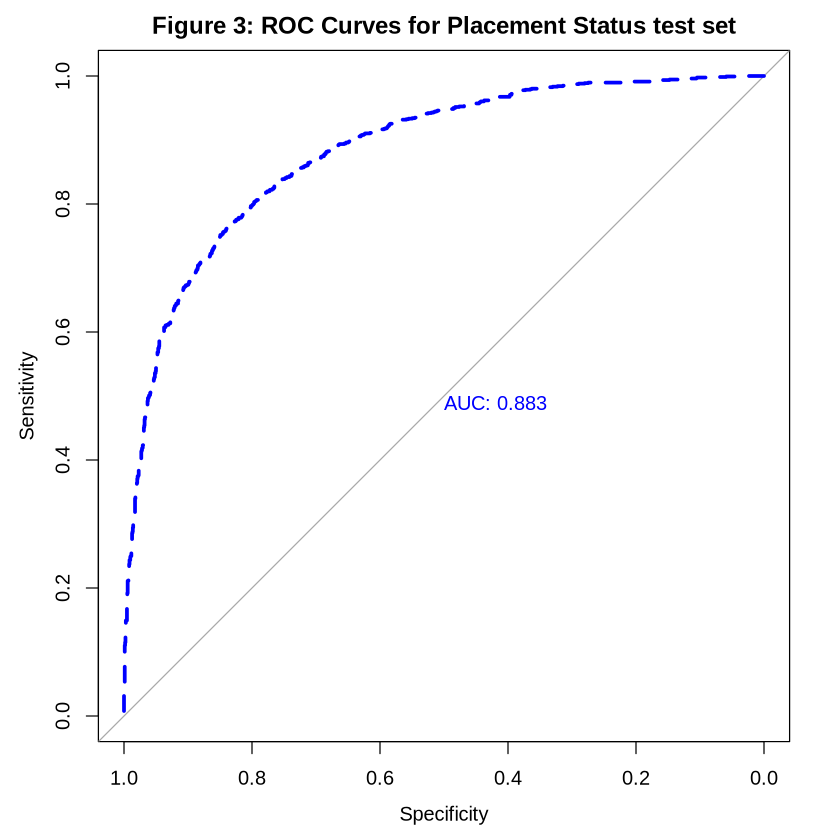

In [20]:

ROC_lasso <- 
    roc(
        response = placement_testing$PlacementStatus,
        predictor = predict(final_model,
                     newx = model_matrix_X_test)[,"s0"] ) 

# Visualization 3: ROC Curve (Figure 3)
plot(ROC_lasso, print.auc = TRUE, col = "blue", lwd = 3, lty = 2,
     main = "Figure 3: ROC Curves for Placement Status test set")

This graph shows a **test-set AUC of 0.883**, which confirms that our final LASSO logistic regression model has a **strong capacity** to distinguish placed from not-placed students, independent of the exact classification threshold.

## Discussion

### Implications and Findings
We initially used a logistic regression to predict whether a student would receive a placement. Using LASSO logistic regression for variable selection, we dropped `Internships` in the final model. This is backed by the model’s strong performance on the test set, with an accuracy of 80.44% and an AUC of 0.883, which indicates reliable classification capability.

CGPA, aptitude test scores, and participation in placement training emerged as strong predictors of successful placement. In contrast, variables such as extracurricular activities and number of projects showed weaker associations with the outcome.

These findings suggest that while well-rounded student profiles are important, traditional academic performance and formal training remain the strongest indicators of employability. Institutions looking to improve placement rates might therefore consider enhancing academic support and offering more structured placement preparation programs.

### Our Expectations with the model

Although our results align with expectations in EDA that `PlacementTraining` contribute positively. It highlights the increasing importance of practical readiness and interpersonal competencies in hiring decisions. 

One limitation, however, is that even though the `Internships` were somehow relevant, they still had their coefficient shrunk to zero, which may be due to overlap with other experience-based features, or due to data imbalance or error

### How can the model be improved?
Although the model performs well, it could be further improved by incorporating more qualitative data such as types of internships, specific training modules completed, or industry-specific placement records. 

### Future Directions

Further research could also examine trends over the years or compare placement success across different universities. Additionally, evaluating employer feedback on hires could help refine which student attributes.

## Reference

#### Sources
- Dataset: Kumbhar, Ruchika. "Placement Prediction Dataset." Kaggle, https://www.kaggle.com/datasets/ruchikakumbhar/placement-prediction-dataset/data.
- Model Training Reference: GeeksforGeeks, Train a Model Using CatBoost, https://www.geeksforgeeks.org/train-a-model-using-catboost/.

#### Collection Methodology
The dataset was likely collected from academic records and placement training programs, which reflects real-world student placement outcomes.
More details on training a machine learning model (e.g., CatBoost) for placement prediction can be found at GeeksforGeeks: https://www.geeksforgeeks.org/train-a-model-using-catboost/.